## Imbalanced Classification

There are a few things to consider, when working with a dataset where the classification variable is highly imbalanced.
Oversampling the minority and undersampling the majority class a effective ways to deal with a imbalanced classifications. But simply duplicating rows in the oversampling part, does not add any value to the dataset.

It would be more effective to synthesize new examples from the known ones. This is where we can a data augmentation method like SMOTE.

> Synthetic Minority Oversampling Technique


https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


Problem with imbalanced classifications: 
- there are too few examples of the minority class in a model to effectively learn the decision boundary.

#### How SMOTE works:
> a random sample from the minority class is chosen. Than  k of the nearest neighbors for that example are found (k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in the feature space.

#### Downside
> synthetic examples are created without considering the majority class,possibly resulting in ambiguous examples if there is a strong overlap of the classes.

In [29]:
# used for oversampling minority
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
# used for downsampling majority
from imblearn.under_sampling import RandomUnderSampler
# import pipeline to chain these two transformations
from imblearn.pipeline import Pipeline

# this generates a random n-class classification problem 
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# we can use the Counter subclass to check the number of classes in the dataset 
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# now create an imbalanced DataSet
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [3]:
X.shape

(10000, 2)

In [4]:
y.shape

(10000,)

In [5]:
counter = Counter(y)

In [6]:
print(counter)

Counter({0: 9900, 1: 100})


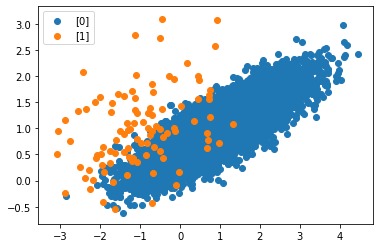

In [7]:
# creat scatterplot from data
for label, _ in counter.items():
    row_ix =np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str([label]))
plt.legend();

#### Oversampling with SMOTE
> SMOTE acts like a data transformer object from scikit-learn 

In [8]:
oversample = SMOTE()

In [9]:
X, y = oversample.fit_resample(X, y)

In [10]:
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


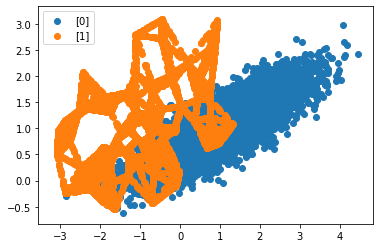

In [11]:
# creat scatterplot from data
for label, _ in counter.items():
    row_ix =np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str([label]))
plt.legend();

We can clearly see the that data points are randomly generated between points

#### Combine SMOTE oversampling with random undersampling of majority class
1. oversample the minority class with SMOTE to have 10% of the majority class (1000)
2. use random undersampling to reduce the number in the majority class to have 50% more than the minority class

In [19]:
# define over and undersampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [20]:
# define pipeline 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [21]:
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [22]:
counter = Counter(y)
print(counter)

Counter({0: 1980, 1: 990})


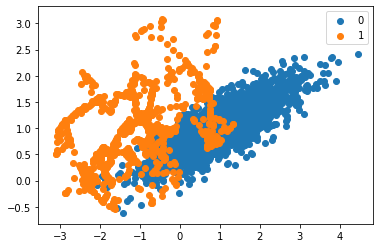

In [23]:
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

> now the data is more balanced, which leads to a better predictive model 

## Use SMOTE for Classification

### Baseline Classification 

In [35]:
# creat new data which isn't transformed allready
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [36]:
model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-2)

In [37]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.767


### Classification with SMOTE
> the correct application of oversampling during kfold cross validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set

In [38]:
# use a pipeline to prevent data leakage
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [39]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-2)

In [40]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.828


### Classification with SMOTE and RandomUnderSampling

In [57]:
# creat new data which isn't transformed allready
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [61]:
# create pipleine
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [62]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [63]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.837


### Enhance predictive score with GridSeach
- SMOTE uses k Nearest Neighbor to crate new data points, with gridsearch we can find the best k

In [67]:
# creat new data which isn't transformed allready
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [71]:
# crate gridsearch pipline
k_vals = [1, 2, 3, 4, 5, 6, 7]
for k in k_vals:
    #define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    score = np.mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.832
> k=2, Mean ROC AUC: 0.832
> k=3, Mean ROC AUC: 0.838
> k=4, Mean ROC AUC: 0.829
> k=5, Mean ROC AUC: 0.851
> k=6, Mean ROC AUC: 0.845
> k=7, Mean ROC AUC: 0.847


k = 5 is the best parameter according to the GridSearch

## SMOTE with selective synthetic sample generation
> SMOTE allows us to be more selective regarding the examples from the minority class that provide the basis for generating new synthetic examples

### Borderline SMOTE
> the examples on the borderline and those nearby are more apt to be misclassified than the ones far from the borderline, and thus more important for classification.

In [17]:
# creat new data which isn't transformed allready
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [6]:
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X, y)

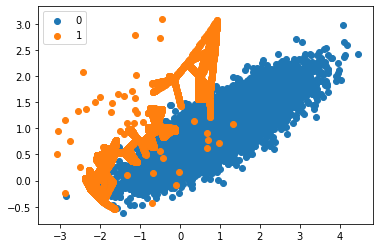

In [10]:
counter = Counter(y)
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()

The plot clearly shows the effect of the selective approach. Examples close to the decision boundary are oversampled whereas examples far from the decision boundary arn't affected by the oversampling.

In [18]:
steps = [('over', BorderlineSMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [19]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-2)

In [20]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.813


### Borderline SMOTE SVM
> An SVM is used to locate the decision boundary defined by the support vectors obtained after training a standard SVM classifier on the original training data. New instances will be randomly created along the lines joining each minority class support vector with a number of its nearest neighbors using the interpolation
> in addition to using an svm , the technique attempts to select regions where there are fewer examples of the minority class and tries to extrapolate towards the class boundary

In [25]:
# creat new data which isn't transformed allready
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [23]:
oversample = SVMSMOTE()
X, y = oversample.fit_resample(X, y)

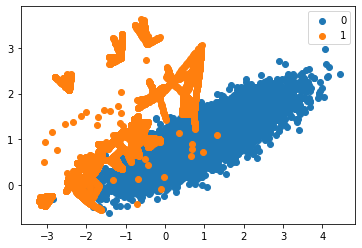

In [24]:
counter = Counter(y)
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()

unlike the Borderline SMOTE, SVM creates new examples away from the decision boundary 

In [26]:
steps = [('over', SVMSMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [27]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-2)

In [28]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.824


### Adaptive Synthetic Sampling (ADASYN)
> generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

In [33]:
# creat new data which isn't transformed allready
X, y = make_classification(n_samples=10000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           flip_y=0,
                           random_state=1)

In [31]:
oversample = ADASYN()
X, y = oversample.fit_resample(X, y)

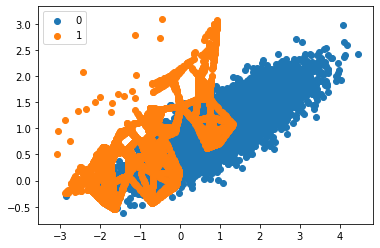

In [32]:
counter = Counter(y)
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()

Unlike Borderline-SMOTE, we can see that the examples that have the most class overlap have the most focus.

-It may help to remove outliers prior to applying the oversampling procedure, and this might be a helpful heuristic to use more generally.

In [34]:
steps = [('over', ADASYN()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

In [35]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-2)

In [36]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.811
